# Basis Functions

### 20th October 2015 Neil Lawrence

We've now seen how we may perform linear regression. Now, we are going to consider how we can perform *non-linear* regression. However, before we get into the details of how to do that we first need to consider in what ways the regression can be non-linear. 

Multivariate linear regression allows us to build models that take many features into account when making our prediction. In this session we are going to introduce *basis functions*. The term seems complicated, but they are actually based on rather a simple idea. If we are doing a multivariate linear regression, we get extra features that *might* help us predict our required response variable (or target value), $y$. But what if we only have one input value? We can actually artificially generate more input values with basis functions.

## Non-linear in the Inputs

When we refer to non-linear regression, we are normally referring to whether the regression is non-linear in the input space, or non-linear in the *covariates*. The covariates are the observations that move with the target (or *response*) variable. In our notation we have been using $\mathbf{x}_i$ to represent a vector of the covariates associated with the $i$th observation. The coresponding response variable is $y_i$. If a model is non-linear in the inputs, it means that there is a non-linear function between the inputs and the response variable. Linear functions are functions that only involve multiplication and addition, in other words they can be represented through *linear algebra*. Linear regression involves assuming that a function takes the form
$$
f(\mathbf{x}) = \mathbf{w}^\top \mathbf{x}
$$
where $\mathbf{w}$ are our regression weights. A very easy way to make the linear regression non-linear is to introduce non-linear functions. When we are introducing non-linear regression these functions are known as *basis functions*.

### Basis Functions

Here's the idea, instead of working directly on the original input space, $\mathbf{x}$, we build models in a new space, $\boldsymbol{\phi}(\mathbf{x})$ where $\boldsymbol{\phi}(\cdot)$ is a *vector valued* function that is defined on the space $\mathbf{x}$. 

Remember, that a vector valued function is just a vector that contains functions instead of values. Here's an example for a one dimensional input space, $x$, being projected to a *quadratic* basis. First we consider each basis function in turn, we can think of the elements of our vector as being indexed so that we have
\begin{align*}
\phi_1(x) = 1, \\
\phi_2(x) = x, \\
\phi_3(x) = x^2.
\end{align*}
Now we can consider them together by placing them in a vector,
$$
\boldsymbol{\phi}(x) = \begin{bmatrix} 1\\ x \\ x^2\end{bmatrix}.
$$
This is the idea of the vector valued function, we have simply collected the different functions together in the same vector making them notationally easier to deal with in our mathematics. 

When we consider the vector valued function for each data point, then we place all the data into a matrix. The result is a matrix valued function,
$$
\boldsymbol{\Phi}(\mathbf{x}) = 
\begin{bmatrix} 1 & x_1 & x_1^2 \\
1 & x_2 & x_2^2\\
\vdots & \vdots & \vdots \\
1 & x_n & x_n^2
\end{bmatrix}
$$
where we are still in the one dimensional input setting so $\mathbf{x}$ here represents a vector of our inputs with $n$ elements. 

Let's try constructing such a matrix for a set of inputs. First of all, we create a function that returns the matrix valued function

In [42]:
import numpy as np # import numpy for the arrays.

def quadratic(x):
    """Take in a vector of input values and return the design matrix associated 
    with the basis functions."""
    return np.hstack([np.ones((n, 1)), x, x**2])


This function takes in an $n\times 1$  dimensional vector and returns an $n\times 3$ dimensional *design matrix* containing the basis functions. We can plot those basis functions against there input as follows.

Text(0.5,1,'Quadratic Basis Functions')

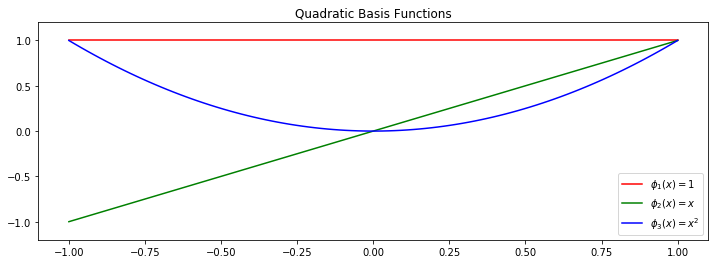

In [43]:
# ensure plots appear in the notebook.
%matplotlib inline 
import pylab as plt

# first let's generate some inputs
n = 100
x = np.zeros((n, 1))  # create a data set of zeros
x[:, 0] = np.linspace(-1, 1, n) # fill it with values between -1 and 1

Phi = quadratic(x)

fig, ax = plt.subplots(figsize=(12,4))
ax.set_ylim([-1.2, 1.2]) # set y limits to ensure basis functions show.
ax.plot(x[:,0], Phi[:, 0], 'r-', label = '$\phi_1(x)=1$')
ax.plot(x[:,0], Phi[:, 1], 'g-', label = '$\phi_2(x) = x$')
ax.plot(x[:,0], Phi[:, 2], 'b-', label = '$\phi_3(x) = x^2$')
ax.legend(loc='lower right')
ax.set_title('Quadratic Basis Functions')

The actual function we observe is then made up of a sum of these functions. This is the reason for the name basis. The term *basis* means 'the underlying support or foundation for an idea, argument, or process', and in this context they form the underlying support for our prediction function. Our prediction function can only be composed of a weighted linear sum of our basis functions. 

### Different Basis

Before we look at the different types of basis functions available, we need to run the following cell of code that will be used in the rest of the notebook. 

In [44]:
# Initial code: it uses pods.notebook.display_prediction, but with a minor modification to 
# allow the use of ipywidgets
from ipywidgets import *
def display_prediction(basis, num_basis=4, wlim=(-1.,1.), fig=None, ax=None, xlim=None, ylim=None, num_points=1000, offset=0.0, **kwargs):
    """Interactive widget for displaying a prediction function based on summing separate basis functions.
    :param basis: a function handle that calls the basis functions.
    :type basis: function handle.
    :param xlim: limits of the x axis to use.
    :param ylim: limits of the y axis to use.
    :param wlim: limits for the basis function weights."""

    #import numpy as np
    #import pylab as plt

    if fig is not None:
        if ax is None:
            ax = fig.gca()

    if xlim is None:
        if ax is not None:
            xlim = ax.get_xlim()
        else:
            xlim = (-2., 2.)
    if ylim is None:
        if ax is not None:
            ylim = ax.get_ylim()
        else:
            ylim = (-1., 1.)

    # initialise X and set up W arguments.
    x = np.zeros((num_points, 1))
    x[:, 0] = np.linspace(xlim[0], xlim[1], num_points)
    param_args = {}
    for i in range(num_basis):
        lim = list(wlim)
        if i ==0:
            lim[0] += offset
            lim[1] += offset
        param_args['w_' + str(i)] = tuple(lim)

    # helper function for making basis prediction.
    def predict_basis(w, basis, x, num_basis, **kwargs):
        Phi = basis(x, num_basis, **kwargs)
        f = np.dot(Phi, w)
        return f, Phi
    
    if type(basis) is dict:
        use_basis = basis[list(basis.keys())[0]]
    else:
        use_basis = basis
    f, Phi = predict_basis(np.zeros((num_basis, 1)),
                           use_basis, x, num_basis,
                           **kwargs)
    if fig is None:
        fig, ax=plt.subplots(figsize=(12,4))
        ax.set_ylim(ylim)
        ax.set_xlim(xlim)

    predline = ax.plot(x, f, linewidth=2)[0]
    basislines = []
    for i in range(num_basis):
        basislines.append(ax.plot(x, Phi[:, i], 'r')[0])

    ax.set_ylim(ylim)
    ax.set_xlim(xlim)

    def generate_function(basis, num_basis, predline, basislines, basis_args, display_basis, offset, **kwargs):
        w = np.zeros((num_basis, 1))
        for i in range(num_basis):
            w[i] = kwargs['w_'+ str(i)]
        f, Phi = predict_basis(w, basis, x, num_basis, **basis_args)
        predline.set_xdata(x[:, 0])
        predline.set_ydata(f)
        for i in range(num_basis):
            basislines[i].set_xdata(x[:, 0])
            basislines[i].set_ydata(Phi[:, i])

        if display_basis:
            for i in range(num_basis):
                basislines[i].set_alpha(1) # make visible
        else:
            for i in range(num_basis):
                basislines[i].set_alpha(0) 
        display(fig)
    if type(basis) is not dict:
        basis = fixed(basis)

    plt.close(fig)
    interact(generate_function, 
             basis=basis,
             num_basis=fixed(num_basis),
             predline=fixed(predline),
             basislines=fixed(basislines),
             basis_args=fixed(kwargs),
             offset = fixed(offset),
             display_basis = False,
             **param_args)


Our choice of basis can be made based on what our beliefs about what is appropriate for the data. For example, the polynomial basis extends the quadratic basis to arbitrary degree, so we might define the $j$th basis function associated with the model as
$$
\phi_j(x_i) = x_i^j
$$
which can be implemented as a function in code as follows

In [45]:
def polynomial(x, num_basis=4, data_limits=[-1., 1.]):
    Phi = np.zeros((x.shape[0], num_basis))
    for i in range(num_basis):
        Phi[:, i:i+1] = x**i
    return Phi

To aid in understanding how a basis works, we've provided you with a small interactive tool for exploring this polynomial basis. The tool can be summoned with the following command.

In [47]:
display_prediction(basis=polynomial, num_basis=4, ylim=[-3.,3])

interactive(children=(Checkbox(value=False, description='display_basis'), FloatSlider(value=0.0, description='w_0', max=1.0, min=-1.0), FloatSlider(value=0.0, description='w_1', max=1.0, min=-1.0), FloatSlider(value=0.0, description='w_2', max=1.0, min=-1.0), FloatSlider(value=0.0, description='w_3', max=1.0, min=-1.0), Output()), _dom_classes=('widget-interact',))

Try moving the sliders around to change the weight of each basis function. Click the control box `display_basis` to show the underlying basis functions (in red). The prediction function is shown in a thick blue line. *Warning* the sliders aren't presented quite in the correct order. `w_0` is associated with the bias, `w_1` is the linear term, `w_2` the quadratic and here (because we have four basis functions) we have `w_3` for the *cubic* term. So the subscript of the weight parameter is always associated with the corresponding polynomial's degree.

### Question 1

Try increasing the number of basis functions (thereby increasing the *degree* of the resulting polynomial). Describe what you see as you increase number of basis up to 10. Is it easy to change the function in intuitive ways?

#### Question 1 Answer

Write your answer to the question in this box.
$$
$$
A: Except the first 2 degree. It is hard to change the function in intuitive ways.

## Radial Basis Functions

Another type of basis is sometimes known as a 'radial basis' because the effect basis functions are constructed on 'centres' and the effect of each basis function decreases as the radial distance from each centre increases. 

In [48]:
# %load -s radial mlai.py
def radial(x, num_basis=4, data_limits=[-1., 1.]):
    "Radial basis constructed using exponentiated quadratic form."
    if num_basis>1:
        centres=np.linspace(data_limits[0], data_limits[1], num_basis)
        width = (centres[1]-centres[0])/2.
    else:
        centres = np.asarray([data_limits[0]/2. + data_limits[1]/2.])
        width = (data_limits[1]-data_limits[0])/2.
    
    Phi = np.zeros((x.shape[0], num_basis))
    for i in range(num_basis):
        Phi[:, i:i+1] = np.exp(-0.5*((x-centres[i])/width)**2)
    return Phi


In [49]:
display_prediction(basis=radial, num_basis=4, ylim=[-2., 2.])

interactive(children=(Checkbox(value=False, description='display_basis'), FloatSlider(value=0.0, description='w_0', max=1.0, min=-1.0), FloatSlider(value=0.0, description='w_1', max=1.0, min=-1.0), FloatSlider(value=0.0, description='w_2', max=1.0, min=-1.0), FloatSlider(value=0.0, description='w_3', max=1.0, min=-1.0), Output()), _dom_classes=('widget-interact',))

## Fourier Basis

Fourier noticed that any *stationary* function could be converted to a sum of sines and cosines. A Fourier basis is a linear weighted sum of these functions.

In [50]:
# %load -s fourier mlai.py
def fourier(x, num_basis=4, data_limits=[-2., 2.]):
    "Fourier basis"
    tau = 2*np.pi
    span = float(data_limits[1]-data_limits[0])
    Phi = np.zeros((x.shape[0], num_basis))
    for i in range(num_basis):
        count = float((i+1)//2)
        frequency = count/span
        if i % 2:
            Phi[:, i:i+1] = np.sin(tau*frequency*x)
        else:
            Phi[:, i:i+1] = np.cos(tau*frequency*x)
    return Phi


In this code, basis functions with an *odd* index are sine and basis functions with an *even* index are cosine. The first basis function (index 0, so cosine) has a frequency of 0 and then frequencies increase to 1, 2, 3, 4 etc every time a sine and cosine are included.

In [51]:
display_prediction(basis=fourier, num_basis=4, ylim=[-1.5, 1.5])

interactive(children=(Checkbox(value=False, description='display_basis'), FloatSlider(value=0.0, description='w_0', max=1.0, min=-1.0), FloatSlider(value=0.0, description='w_1', max=1.0, min=-1.0), FloatSlider(value=0.0, description='w_2', max=1.0, min=-1.0), FloatSlider(value=0.0, description='w_3', max=1.0, min=-1.0), Output()), _dom_classes=('widget-interact',))

In [52]:
# %load -s relu mlai.py
def relu(x, num_basis=4, data_limits=[-1., 1.], gain=None):
    "Rectified linear units basis"
    if num_basis>2:
        centres=np.linspace(data_limits[0], data_limits[1], num_basis)
    else:
        centres = np.asarray([data_limits[0]/2. + data_limits[1]/2.])
    if gain is None:
        gain = np.ones(num_basis-1)
    Phi = np.zeros((x.shape[0], num_basis))
    # Create the bias
    Phi[:, 0] = 1.0
    for i in range(1, num_basis):
        Phi[:, i:i+1] = (gain[i-1]*x>centres[i-1])*(x-centres[i-1])
    return Phi


In [53]:
display_prediction(basis=relu, num_basis=4, ylim=[-2., 2.])

interactive(children=(Checkbox(value=False, description='display_basis'), FloatSlider(value=0.0, description='w_0', max=1.0, min=-1.0), FloatSlider(value=0.0, description='w_1', max=1.0, min=-1.0), FloatSlider(value=0.0, description='w_2', max=1.0, min=-1.0), FloatSlider(value=0.0, description='w_3', max=1.0, min=-1.0), Output()), _dom_classes=('widget-interact',))

## Fitting to Data

Now we are going to consider how these basis functions can be adjusted to fit to a particular data set. We will return to the olympic marathon data from last time. First we will scale the output of the data to be zero mean and variance 1.

In [54]:
import pods
data = pods.datasets.olympic_marathon_men()
y = data['Y']
x = data['X']
y -= y.mean()
y /= y.std()

### Question 2

Now we are going to redefine our polynomial basis. Have a careful look at the operations we perform on `x` to create `z`. We use `z` in the polynomial computation. What are we doing to the inputs? Why do you think we are changing `x` in this manner?

#### Question 2 Answer

Write your answer to the question in this box.
$$
$$
A: Because we are trying to extend 1 input into several input values. It helps to describe the data more precisely.

In [55]:
# %load -s polynomial mlai.py
def polynomial(x, num_basis=4, data_limits=[-1., 1.]):
    "Polynomial basis"
    centre = data_limits[0]/2. + data_limits[1]/2.
    span = data_limits[1] - data_limits[0]
    z = x - centre
    z = 2*z/span
    Phi = np.zeros((x.shape[0], num_basis))
    for i in range(num_basis):
        Phi[:, i:i+1] = z**i
    return Phi


In [39]:
#x[:, 0] = np.linspace(1888, 2020, 1000)
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(x, y, 'rx')
display_prediction(basis=dict(radial=radial, polynomial=polynomial, fourier=fourier, relu=relu), 
                                 ylim=[-2.0, 4.],
                                 data_limits=(1888, 2020),
                                 fig=fig, ax=ax,
                                 offset=0.,
                                 wlim = (-4, 4),
                                 num_basis=4)

interactive(children=(Dropdown(description='basis', options={'radial': <function radial at 0x180c38cbf8>, 'polynomial': <function polynomial at 0x180c17cf28>, 'fourier': <function fourier at 0x180c79b840>, 'relu': <function relu at 0x1086d5f28>}, value=<function radial at 0x180c38cbf8>), Checkbox(value=False, description='display_basis'), FloatSlider(value=0.0, description='w_0', max=4.0, min=-4.0), IntSlider(value=0, description='w_1', max=4, min=-4), IntSlider(value=0, description='w_2', max=4, min=-4), IntSlider(value=0, description='w_3', max=4, min=-4), Output()), _dom_classes=('widget-interact',))

### Question 3

Use the tool provided above to try and find the best fit you can to the data. Explore the parameter space and give the weight values you used for the 

(a) polynomial basis
(b) RBF basis
(c) Fourier basis

Write your answers in the code box below creating a new vector of parameters (in the correct order!) for each basis.

In [ ]:
# Question 3 Answer Code

# (a) polynomial
###### Edit these lines #####
w_0 = -0.3
w_1 = -2
w_2 = 1
w_3 = 1
##############################
w_polynomial = np.asarray([[w_0], [w_1], [w_2], [w_3]]) 

# (b) rbf
###### Edit these lines #####
w_0 = 2.2
w_1 = 0
w_2 = -1
w_3 = 0
##############################
w_rbf = np.asarray([[w_0], [w_1], [w_2], [w_3]]) 

# (c) fourier
###### Edit these lines #####
w_0 = -0.2
w_1 = 0
w_2 = -1
w_3 = -1
##############################
w_fourier = np.asarray([[w_0], [w_1], [w_2], [w_3]]) 

In [ ]:
np.asarray([[1, 2, 3, 4]]).shape

We like to make use of *design* matrices for our data. Design matrices, as you will recall, involve placing the data points into rows of the matrix and data features into the columns of the matrix. By convention, we are referencing a vector with a bold lower case letter, and a matrix with a bold upper case letter. The design matrix is therefore given by
$$
\boldsymbol{\Phi} = \begin{bmatrix} 1 & \mathbf{x} & \mathbf{x}^2\end{bmatrix}
$$


### Non-linear but linear in the Parameters

One rather nice aspect of our model is that whilst it is non-linear in the inputs, it is still linear in the parameters $\mathbf{w}$. This means that our derivations from before continue to operate to allow us to work with this model. In fact, although this is a non-linear regression it is still known as a *linear model* because it is linear in the parameters, 
$$
f(\mathbf{x}) = \mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})
$$
where the vector $\mathbf{x}$ appears inside the basis functions, making our result, $f(\mathbf{x})$ non-linear in the inputs, but $\mathbf{w}$ appears outside our basis function, making our result *linear* in the parameters. In practice, our basis function itself may contain its own set of parameters,
$$
f(\mathbf{x}) = \mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x}; \boldsymbol{\theta}),
$$
that we've denoted here as $\boldsymbol{\theta}$. If these parameters appear inside the basis function then our model is *non-linear* in these parameters.

### Question 4
For the following prediction functions state whether the model is linear in the inputs, the parameters or both.

(a) $f(x) = w_1x_1 + w_2$

(b) $f(x) = w_1\exp(x_1) + w_2x_2 + w_3$

(c) $f(x) = \log(x_1^{w_1}) + w_2x_2^2 + w_3$

(d) $f(x) = \exp(-\sum_i(x_i - w_i)^2)$

(e) $f(x) = \exp(-\mathbf{w}^\top \mathbf{x})$

#### Question 4 Answer

Write your answer to the question in this box.
$$
$$
A:  a)both are
    b)parameters
    c)parameters
    d)both not
    e)both not

## Fitting the Model Yourself

You now have everything you need to fit a non-linear (in the inputs) basis function model to the marathon data. 

### Question 5

Choose one of the basis functions you have explored above. Compute the design matrix on the covariates (or input data), `x`. Use the design matrix and the response variable `y` to solve the following linear system for the model parameters `w`.
$$
\boldsymbol{\Phi}^\top\boldsymbol{\Phi}\mathbf{w} = \boldsymbol{\Phi}^\top \mathbf{y}
$$
Compute the corresponding error on the training data. How does it compare to the error you were able to achieve fitting the basis above? Plot the form of your prediction function from the least squares estimate alongside the form of you prediction function you fitted by hand.

In [ ]:
# Question 5 Answer Code
# Write code for you answer to this question in this box
Phi = polynomial(x,9,[1896.,2012.])
# Phi = radial(x,8,[1896.,2012.])
# Phi = fourier(x,7,[1896.,2012.])
# print(Phi.shape)
# print(np.dot(Phi.T,Phi))
w = np.linalg.solve(np.dot(Phi.T,Phi),np.dot(Phi.T,y))
# print(w.shape)
coordinate = []
error = 0
for i in range(Phi.shape[0]):
    coordinate.append(np.dot(w.T,Phi[i]))
    error_per_line = np.dot((y-np.dot(w.T,Phi[i])).T,(y-np.dot(w.T,Phi[i])))
    error += error_per_line
print("Objective error is: ",error_per_line/Phi.shape[0])
print(w)
plt.plot(x,y)
plt.show()
plt.plot(x,coordinate)
plt.show()

## Use of QR Decomposition for Numerical Stability

In the last session we showed how rather than computing $\mathbf{X}^\top\mathbf{X}$  as an intermediate step to our solution, we could compute the solution to the regressiond directly through [QR-decomposition](http://en.wikipedia.org/wiki/QR_decomposition). Now we will consider an example with non linear basis functions where such computation is critical for forming the right answer. 

Can you solve *Assignment Question 5* using QR decomposition?